<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/MDF/blob/main/TestePINO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U neuraloperator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 71.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from neuralop.models import FNO
import numpy as np
import matplotlib.pyplot as plt

def generate_advection_diffusion(Nx=64, Ny=64, Nt=50, L=1.0, T=1.0, v_x=1.0, v_y=0.5, D=0.01, x0=0.5, y0=0.5):
  dx = L / (Nx - 1)
  dy = L / (Ny - 1)
  dt = 0.001
  x = np.linspace(0, L, Nx)
  y = np.linspace(0, L, Ny)
  X, Y = np.meshgrid(x, y, indexing='ij')

  c = np.zeros((Nt, Nx, Ny))
  c[0] = np.exp(-100 * ((X - x0)**2 + (Y - y0)**2))

  for n in range(0, Nt - 1):
    for i in range(1, Nx - 1):
      for j in range(1, Ny - 1):
        adv_x = -v_x * (c[n, i, j] - c[n, i - 1, j]) / dx
        adv_y = -v_y * (c[n, i, j] - c[n, i, j - 1]) / dy
        diff_x = D * (c[n, i + 1, j] - 2 * c[n, i, j] + c[n, i - 1, j]) / dx ** 2
        diff_y = D * (c[n, i, j + 1] - 2 * c[n, i, j] + c[n, i, j - 1]) / dy ** 2
        c[n + 1, i, j] = c[n, i, j] + dt * (adv_x + adv_y + diff_x + diff_y)
  return c

num_cases = 5
c_data_list = []
for _ in range(num_cases):
  x0 = np.random.uniform(0.0, 1.0)
  y0 = np.random.uniform(0.0, 1.0)
  c_data_list.append(generate_advection_diffusion(x0=x0, y0=y0))

c_data = np.stack(c_data_list)

X_train = torch.tensor(c_data[:, :-1]).unsqueeze(2).float()  # (num_cases, Nt-1, 1, Nx, Ny)
Y_train = torch.tensor(c_data[:, 1:]).unsqueeze(2).float()
X_train_flat = X_train.reshape(-1, 1, 64, 64)  # (num_cases*(Nt-1), 1, Nx, Ny)
Y_train_flat = Y_train.reshape(-1, 1, 64, 64)

print(f"X_train_flat shape: {X_train_flat.shape}")

#modelo fno
modelo = FNO(n_modes=(12,12), hidden_channels=32, in_channels=1, out_channels=1)

def EDP(pred, input_tensor, v_x=1.0, v_y=0.5, D=0.01, dx=1/63, dy=1/63, dt=0.001):
  dc_dt = (pred - input_tensor) / dt
  dc_dx = (pred - torch.roll(pred, 1, dims=2)) / dx
  dc_dy = (pred - torch.roll(pred, 1, dims=3)) / dy
  d2c_dx2 = (torch.roll(pred, -1, dims=2) - 2*pred + torch.roll(pred, 1, dims=2)) / dx**2
  d2c_dy2 = (torch.roll(pred, -1, dims=3) - 2*pred + torch.roll(pred, 1, dims=3)) / dy**2
  res = dc_dt + v_x * dc_dx + v_y * dc_dy - D * (d2c_dx2 + d2c_dy2)
  return torch.mean(res**2)

loss_fn = nn.MSELoss()
otimizador = optim.Adam(modelo.parameters(), lr=0.001)

for epoch in range(1000):
  modelo.train()
  otimizador.zero_grad()
  output = modelo(X_train_flat)

  loss_data = loss_fn(output, Y_train_flat)
  loss_pde = EDP(output, X_train_flat)
  loss = loss_data + 1.0 * loss_pde

  loss.backward()
  otimizador.step()

  print(f"Epoch {epoch+1}: Loss_data={loss_data.item():.6f}, Loss_pde={loss_pde.item():.6f}")

with torch.no_grad():
  idx = 10  # pegar o primeiro passo do primeiro caso
  pred = modelo(X_train_flat[idx:idx+1]).squeeze().cpu().numpy()
  real = Y_train_flat[idx].squeeze().cpu().numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Real")
plt.imshow(real, cmap='jet')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("PINO")
plt.imshow(pred, cmap='jet')
plt.colorbar()
plt.show()


X_train_flat shape: torch.Size([245, 1, 64, 64])
Epoch 1: Loss_data=0.011410, Loss_pde=11494.621094
Epoch 2: Loss_data=0.011299, Loss_pde=11385.273438
Epoch 3: Loss_data=0.011314, Loss_pde=11399.929688
Epoch 4: Loss_data=0.011142, Loss_pde=11227.305664
Epoch 5: Loss_data=0.011109, Loss_pde=11193.649414
Epoch 6: Loss_data=0.011148, Loss_pde=11232.265625
Epoch 7: Loss_data=0.011098, Loss_pde=11181.611328
Epoch 8: Loss_data=0.010996, Loss_pde=11080.021484
Epoch 9: Loss_data=0.010938, Loss_pde=11021.730469
Epoch 10: Loss_data=0.010926, Loss_pde=11010.057617
Epoch 11: Loss_data=0.010888, Loss_pde=10971.494141
Epoch 12: Loss_data=0.010797, Loss_pde=10879.377930
Epoch 13: Loss_data=0.010695, Loss_pde=10777.445312
Epoch 14: Loss_data=0.010619, Loss_pde=10700.372070
Epoch 15: Loss_data=0.010544, Loss_pde=10624.434570
Epoch 16: Loss_data=0.010428, Loss_pde=10507.516602
Epoch 17: Loss_data=0.010272, Loss_pde=10350.759766
Epoch 18: Loss_data=0.010107, Loss_pde=10185.280273
Epoch 19: Loss_data=0.00

KeyboardInterrupt: 

<ipython-input-4-4c30c747145e>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(num_plot_cases, 3, figsize=(12, 4*num_plot_cases))


GIF salvo como 'comparacao_pino.gif'


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

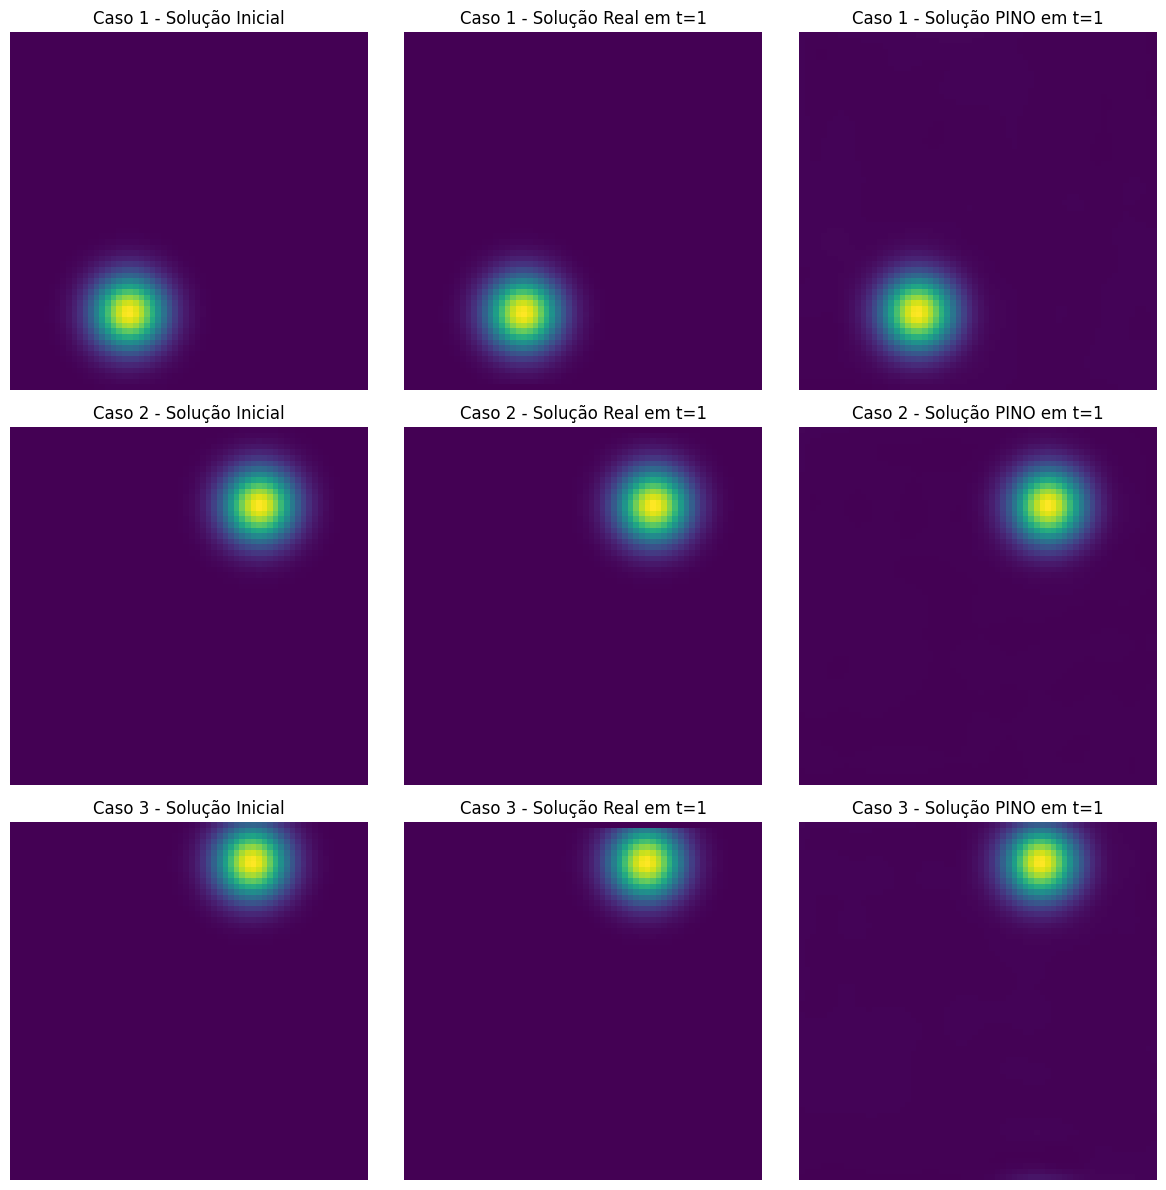

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 1️⃣ Pegar 9 casos diferentes (ou menos se tiver menos)
num_plot_cases = min(3, num_cases)
steps = X_train.shape[1]  # número de passos de tempo (Nt-1)

# 2️⃣ Fazer predições de todos os passos para os 9 casos
pred_list = []
with torch.no_grad():
    for i in range(num_plot_cases):
        preds = []
        input_t = X_train[i,0:1]
        for t in range(steps):
            output_t = modelo(input_t.reshape(1,1,64,64))
            preds.append(output_t.squeeze(0).cpu().numpy())
            input_t = output_t  # usa predição como próxima entrada
        pred_list.append(np.stack(preds))  # (steps, 64, 64)

# 3️⃣ Função de plot para cada frame
def plot_frame(t_idx):
    fig, axes = plt.subplots(num_plot_cases, 3, figsize=(12, 4*num_plot_cases))
    for i in range(num_plot_cases):
        # dados reais
        real_init = X_train[i,0,0].cpu().numpy().squeeze()
        real_true = Y_train[i,t_idx,0].cpu().numpy().squeeze()
        pred = pred_list[i][t_idx].squeeze()

        axes[i,0].imshow(real_init, cmap='viridis')
        axes[i,0].set_title(f'Caso {i+1} - Solução Inicial')

        axes[i,1].imshow(real_true, cmap='viridis')
        axes[i,1].set_title(f'Caso {i+1} - Solução Real em t={t_idx+1}')

        axes[i,2].imshow(pred, cmap='viridis')
        axes[i,2].set_title(f'Caso {i+1} - Solução PINO em t={t_idx+1}')

        for j in range(3):
            axes[i,j].axis('off')
    plt.tight_layout()
    return fig

# 4️⃣ Criar animação
fig = plt.figure()

def animate(t_idx):
    plt.clf()
    return plot_frame(t_idx)

ani = animation.FuncAnimation(fig, animate, frames=steps, repeat=False)

# 5️⃣ Salvar como GIF
ani.save('comparacao_pino.gif', writer='pillow', fps=5)

print("GIF salvo como 'comparacao_pino.gif'")

<ipython-input-4-4c30c747145e>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(num_plot_cases, 3, figsize=(12, 4*num_plot_cases))


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

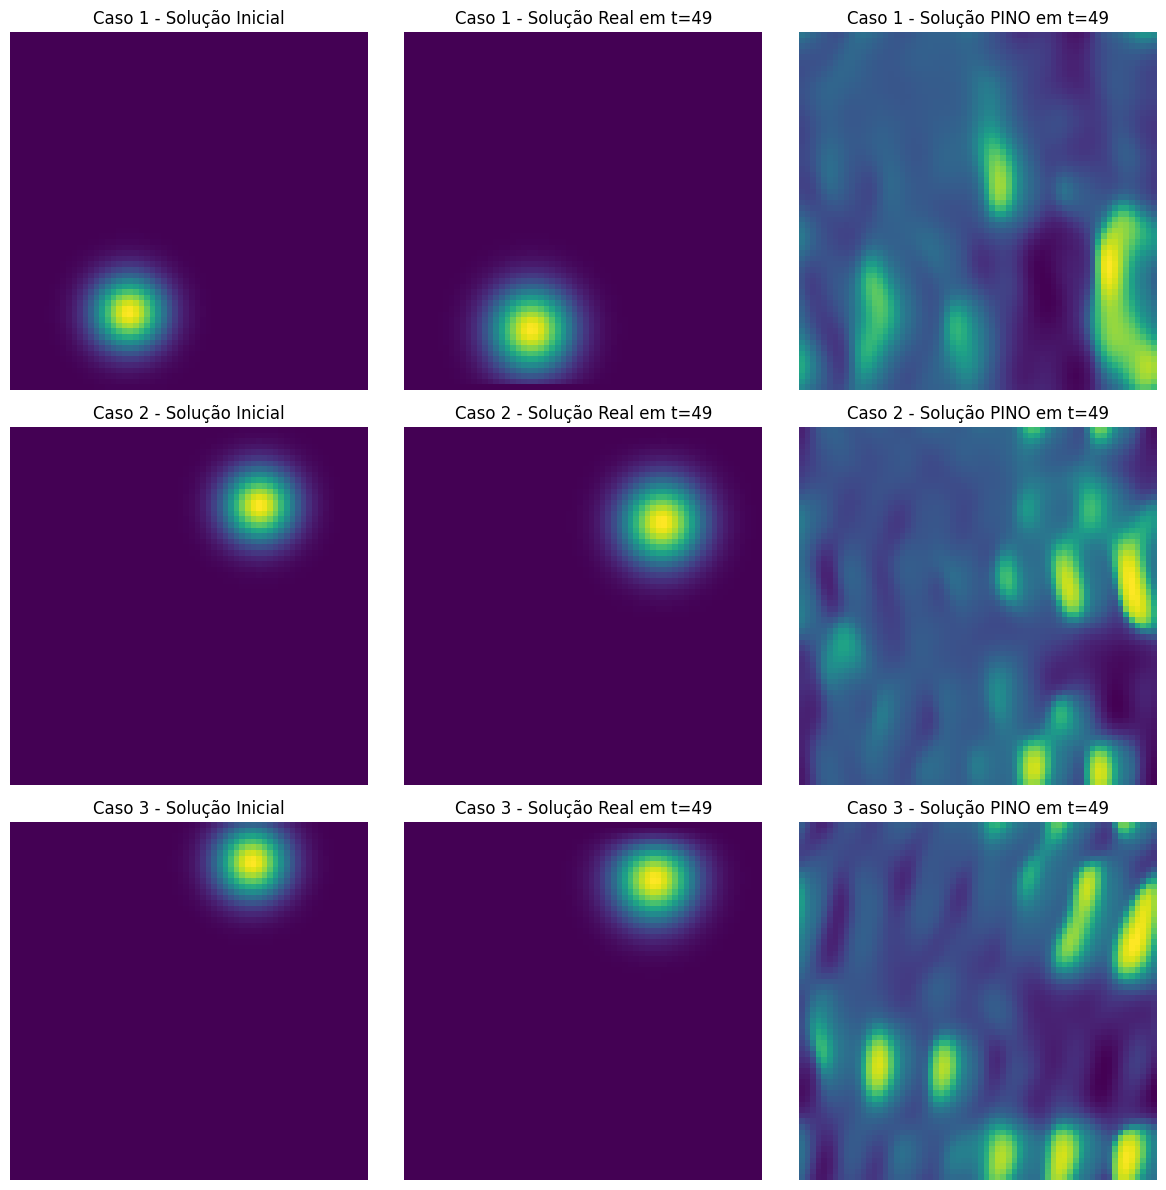

In [5]:
from IPython.display import HTML
HTML(ani.to_jshtml())